###  Calculation of the observables
* We will start with reproducing the results of the quenched xy model.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
conf1 = pd.read_csv('sudden_quench_sweepspinconf_L64.dat',sep='\t',header=None)
col_names = []
col_names.append('time')
col_names.extend([f'theta{i}' for i in range(4097)])
conf1.columns = col_names

conf1.drop(col_names[-1],axis=1,inplace=True)
conf1.tail()


,time,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,...,theta4086,theta4087,theta4088,theta4089,theta4090,theta4091,theta4092,theta4093,theta4094,theta4095
2995,2995.0,-2.241835,-2.510902,-2.764798,2.374353,2.754889,3.088828,2.701988,-2.253330,-2.38346,...,-2.082923,-1.914092,-2.385437,-2.562361,-2.671939,-2.618603,-2.992272,-2.991832,-3.125287,-2.862436
2996,2996.0,-2.106726,-2.510902,-2.764798,2.374353,2.754889,3.088828,2.766816,2.119929,-2.38346,...,-2.082923,-1.914092,-2.385437,-2.562361,-2.671939,-2.618603,-2.992272,-2.991832,-3.125287,-2.862436
2997,2997.0,-2.106726,-2.510902,-2.764798,2.374353,2.754889,3.088828,2.766816,-2.436240,-2.38346,...,-1.377109,-1.914092,-2.385437,-2.562361,-2.671939,-2.618603,-2.992272,-2.991832,-2.598352,-2.862436
2998,2998.0,-2.106726,-2.510902,-2.764798,2.374353,2.754889,3.088828,2.766816,-2.701200,-2.38346,...,-1.430900,-1.914092,-2.385437,-2.562361,-2.671939,-2.618603,-2.992272,-2.991832,-2.828206,-2.862436
2999,2999.0,-1.731462,-2.510902,-1.969315,2.374353,2.754889,3.088828,2.766816,-2.701200,-2.38346,...,-1.430900,-1.914092,-2.385437,-2.961951,-2.671939,-2.600708,-2.992272,-2.991832,-2.828206,-2.862436


### Observables

\begin{equation}
\chi(t) = \frac{1}{L^{2}}\vec{M}^{2}(t) 
\end{equation}
 
$\vec{M}(t) = \sum_{i}\vec{s}_{i}(t) = \sum_{i}s_{x,i}(t) + \sum_{i}s_{y,i}(t) = \sum_{i}\cos \theta_{i}(t) + \sin \theta_{i}(t) = \theta_{i,}$
* The second moment of correlation length is given by,
\begin{equation}
\xi^{2}(t)  = \frac{1}{(2\sin(\pi/L))^{2}}\left(\frac{\chi(t)}{F(t)} - 1\right)
\end{equation}

Where,
\begin{equation}
F(t) = \frac{1}{L^{2}}\sum_{ij}\langle\vec{s_{i}(t)}.\vec{s_{j}(t)} \rangle \cos(2\pi(j_{x}-i_{x}))
\end{equation}
* This in turn can be simplified further,
* $ \langle\vec{s_{i}(t)}.\vec{s_{j}(t)} \rangle = \langle s_{x,i}(t)s_{x,j}(t) + s_{y,i}(t)s_{y,j}(t)  \rangle $
* $\cos(2 \pi(j_{x}-i_{x})) = \cos(2\pi(j\%L - i\%L))$

In [3]:
class Observables:
    def __init__(self,f1):
        self.data = f1
        self.temp = f1.time 
        self.n_sites = (int)(len(f1.columns)-1)
        self.L  = (int)(np.sqrt(self.n_sites))
        self.colnames = list(f1.columns)
        self.thetas = list(self.colnames[1:])
        self.site_arr = np.arange(self.n_sites)
        
    
    ## function to calculate the phase that is multiplied with the spin-spin correlation function
    def phase_mat(self):
        temp_mat = np.zeros((self.L,self.L))
        for i,j in product(np.arange(self.L),np.arange(self.L)):
            temp_mat[i,j] = np.cos(2*np.pi*(i-j))
        self.cosphase = temp_mat
        
    ## this function will calculate the x and y index of each site
    def calculate_siteindex(self):
        self.X_site = np.array(list(map(lambda x:x%self.L,
                    np.array([i for i in range(self.n_sites)]))))
        self.Y_site = np.array(list(map(lambda x: x // self.L,\
                    np.array([i for i in range(self.n_sites)]))))

    ## this function will calculate x and y component of using theta
    ## sx-->cos(theta), sy-->sin(theta)

    def calculate_sx(self):
        temp_data = self.data
        temp_data_sy = temp_data[self.thetas].apply(lambda x:np.sin(x))
        temp_data_sx = temp_data[self.thetas].apply(lambda x: np.cos(x))

        self.data_sx = temp_data_sx
        self.data_sy = temp_data_sy
    
    ## calculate m(t) = sum(sx(t)) + sum(sy(t))
    ## to sum over all the values of theta sum over all the columns(axis=1).
    def calculate_mt(self):
        self.mxt =  self.data_sx.sum(axis=1)
        self.myt = self.data_sy.sum(axis=1)

    ## calculate chi(t) 
    def M2_calc(self):
        self.M2 = (self.mxt)**2 + (self.myt)**2
        self.chit = (self.M2)/self.n_sites
    
    ## to calculate the correlation functions
    def corr_funct(self,t):
        data_x = self.data_sx.iloc[t,:]
        data_y = self.data_sy.iloc[t,:]
        sum_xx = 0.0
        sum_yy = 0.0
        sum_xy = 0.0
        corr_func = np.zeros((self.L , self.L))
        for i,j in product(self.site_arr,self.site_arr):
            sum_xx,sum_yy = data_x[i]*data_x[j],data_y[i]*data_y[j]
            xi,xj = i%self.L,j%self.L
            sum_xy = (sum_xx + sum_yy)*self.cosphase[xi][xj]
            corr_func[i,j]+=sum_xy
        return corr_func.sum()
    
    ## calcualte the time dependent correlation function
    def t_dep_corrfunc(self):
        corr_t = []
        for j in range(100):
            corr_t.append(self.corr_funct(j))
        self.ct = corr_t
        
            

In [4]:
## instantiate the object
obs1 = Observables(conf1)

## initialize the phase matrix(the one that is multiplied with the spin-spin correlation function)
obs1.phase_mat()

## calculate the x and y index of the lattice site
obs1.calculate_siteindex()

## calculate the sx and sy component of the spin
obs1.calculate_sx()

## calculate mt from the data
obs1.calculate_mt()

## calculate the M2 and chit from the data
obs1.M2_calc()

## calculating the correlation function 
obs1.t_dep_corrfunc()


IndexError: index 64 is out of bounds for axis 1 with size 64

In [169]:
(obs1.chit[:100]/obs1.ct) - 1

0    -0.998264
1    -0.998264
2    -0.998264
3    -0.998264
4    -0.998264
        ...   
95   -0.998264
96   -0.998264
97   -0.998264
98   -0.998264
99   -0.998264
Length: 100, dtype: float64

In [143]:
obs1.chit.iloc[100]/((1./obs1.n_sites)*outp.sum())-1

7.105427357601002e-15

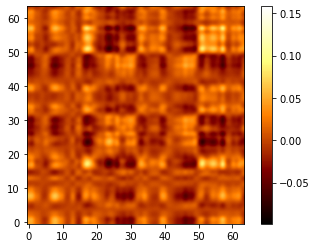

In [121]:
plt.imshow(outp/(obs1.n_sites),origin='lower',cmap='afmhot',interpolation='bicubic')
plt.colorbar()
plt.show()

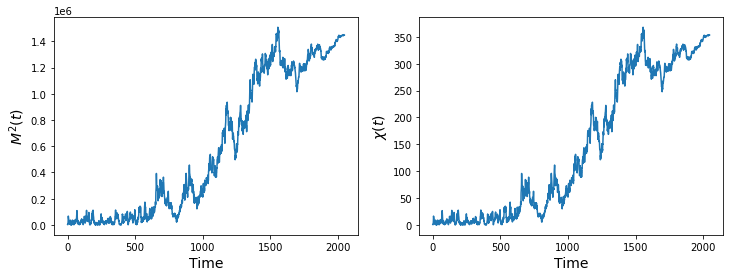

In [65]:
f,ax=plt.subplots(1,2,figsize=(12,4))
obs1.M2.plot(kind='line',ax=ax[0])
ax[0].set_xlabel('Time',fontsize=14)
ax[0].set_ylabel(r'$M^{2}(t)$',fontsize=14)

obs1.chit.plot(kind='line',ax=ax[1])
ax[1].set_xlabel('Time',fontsize=14)
ax[1].set_ylabel(r'$\chi(t)$',fontsize=14)

plt.show()


### Correlation function calculation
* The correlation $C(r,t)$ function is given by,
\begin{eqnarray*}
C(r,t) &=& \sum_{ij}\langle \vec{S}_{i,t}. \vec{S}_{j,t}  \rangle_{|r_{i}-r_{j}|=r} \\
C(r,t) &=& \sum_{ij}\langle S^{x}_{i,t} S^{x}_{j,t} + S^{y}_{i,t} S^{y}_{j,t}  \rangle_{|r_{i}-r_{j}|=r}
\end{eqnarray*}

In [285]:
### sdn quench class is inheriting from the Observables class
class sdnquench(Observables):
    ## instantiating the object
    def __init__(self,f1):
        super().__init__(f1)
    
    ### correlation function calculation
    def corr_rt(self,t):
        data_x = self.data_sx.iloc[t,:]
        data_y = self.data_sy.iloc[t,:]
        sloc_x,sloc_y = 0.0,0.0
        temp = np.zeros((self.L,self.L))
        sum_dict = {}
        sx_copy = data_x.copy()
        sy_copy = data_y.copy()
       
        data_x = data_x.values.reshape(-1,1)
        data_y = data_y.values.reshape(-1,1)

       
        sx_copy = sx_copy.values.reshape(1,-1)
        sy_copy = sy_copy.values.reshape(1,-1)

        temp_xmat = np.matmul(data_x,sx_copy)
        temp_ymat = np.matmul(data_y,sy_copy)
        print(xmat.shape)
        #for i,j in product(np.arange(self.n_sites),np.arange(self.n_sites)):
        #    sloc_x = data_x[i]*data_x[j]
        #    sloc_y = data_y[i]*data_y[j]
        #    sum_sisj = sloc_x + sloc_y
            ## get the x index of site i and site j
        #    xi,xj = self.X_site[i],self.X_site[j]
            
            ## get the y index of the site i and site j
        #    yi,yj = self.Y_site[i],self.Y_site[j]
            
            ## calculate the minimum distance between the site i and j 
            ## taking into account the periodic boundary conditions
        #    dx = min(abs(xi-xj),self.L-abs(xi-xj))
        #    dy = min(abs(yi-yj),self.L-abs(yi-yj))    
            
            ## sum all the values for the same value of distance dx and dy
        #    temp[dx,dy] += sum_sisj    
            
        #self.c_rt = temp
    
   
    

In [286]:
obssd = sdnquench(conf1)
obssd.calculate_siteindex()
obssd.calculate_sx()
obssd.corr_rt(2)

(16384, 1)
(16384, 16384)


In [249]:
corr_r={}
for i,j in product(np.arange(obssd.L),np.arange(obssd.L)):
    corr_r[np.sqrt(i**2+j**2)] = obssd.c_rt[i,j]/obssd.n_sites
    

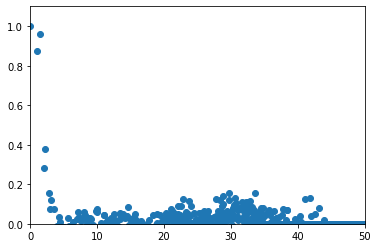

In [252]:
xi = corr_r.keys()
yi = corr_r.values()
plt.plot(xi,yi,marker='o',linestyle='')
plt.axis([0,50,0,1.1])
plt.show()

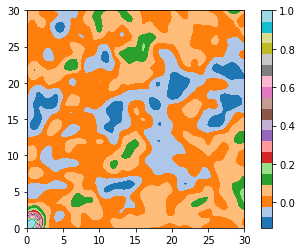

In [251]:
plt.imshow(obssd.c_rt/obssd.n_sites,origin='lower',cmap='tab20',interpolation='spline36')
#plt.axis([0,30,0,30])
plt.colorbar()
plt.show()

In [259]:
conf1 = pd.read_csv('sudden_quench_sweepspinconf_L128.dat',sep='\t',header=None)


In [269]:
col_names = []
col_names.append('time')
col_names.extend([f'theta{i}' for i in range(128**2+1)])

conf1.columns = col_names

conf1.drop(col_names[-1],axis=1,inplace=True)


In [270]:
conf1.head()

,time,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,...,theta16374,theta16375,theta16376,theta16377,theta16378,theta16379,theta16380,theta16381,theta16382,theta16383
0,0.0,-1.579788,-2.976528,-2.443357,2.866932,1.128343,1.750892,-3.083306,-1.746857,-1.956336,...,-1.512534,2.809467,-3.048221,-1.959672,-2.821117,1.857293,1.347982,-2.106826,0.221516,2.760473
1,1.0,-0.347868,-2.976528,2.580709,2.866932,1.128343,1.021770,-3.083306,-2.230213,-1.956336,...,-1.512534,2.809467,2.924956,-1.959672,-2.821117,1.857293,1.347982,-1.400489,0.221516,0.228019
2,2.0,-0.016639,-2.976528,2.580709,2.866932,3.095160,-2.780045,-3.083306,-2.230213,-1.956336,...,-1.895967,2.809467,2.924956,-2.521735,-2.821117,1.857293,3.114481,-2.083053,0.221516,0.228019
3,3.0,-0.016639,-2.976528,2.580709,2.866932,3.095160,-2.780045,-3.083306,-2.230213,-1.296322,...,-1.895967,2.809467,2.924956,-2.521735,-2.821117,1.857293,2.715290,-2.555816,0.221516,0.228019
4,4.0,-0.016639,-2.976528,2.580709,2.866932,3.095160,-1.965875,-3.083306,-2.230213,-1.296322,...,-0.989074,2.809467,2.924956,-2.521735,-2.821117,1.857293,2.715290,2.345677,0.569519,0.228019


In [268]:
128*128

16384

<ol>
<li> $**0**$,1,2,3,**4**,5,6,7 </li>
\item 0,**1**,2,3,4,**5**,6,7
\item **0**,1,2,3,**4**,5,6,7
\item **0**,1,2,3,**4**,5,6,7
\item **0**,1,2,3,**4**,5,6,7
</ol>